# Prestiti oltre il breve termine (esclusi PCT e sofferenze): 

erogazioni per **destinazione** economica, condizione e provincia dell'investimento

#TFR10430 #erogazioni

vedi anche TFR10430|Prestiti oltre il breve termine (esclusi PCT e sofferenze): **consistenze** per destinazione economica, condizione e provincia dell'investimento T SV 

- TIPTASSO	10000	Totale tasso agevolato e non
- TIPTASSO	80	Tasso agevolato
- TIPTASSO	800	Tasso non agevolato


- DESINV	10	Investimenti non finanziari: costruzioni - abitazioni
- DESINV	110	Altri investimenti: acquisto di beni durevoli da parte delle famiglie consumatrici
- DESINV	120	Investimenti finanziari
- DESINV	20	Investimenti non finanziari: costruzioni - fabbricati non residenziali rurali
- DESINV	212	Prestiti per acquisto abitazioni
- DESINV	40	Investimenti non finanziari: costruzioni - opere del genio civile
- DESINV	50	Investimenti non finanziari: macchine,attrezz., mezzi di trasporto e prodotti vari rurali
- DESINV	70	Investimenti: acquisto immobili - abitazioni famiglie consumatrici
- DESINV	80	Investimenti: acquisto immobili - abitazioni di altri soggetti
- DESINV	90	Investimenti: acquisto immobili - immobili rurali
- DESINV	902	Investimenti non finanziari: costruzioni - fabbricati non residenziali
- DESINV	905	Investimenti non finanziari: macchine, attrezz., mezzi di trasporto e prodotti vari
- DESINV	909	Investimenti: acquisto di immobili - altri immobili
- DESINV	912	Investimenti non finanziari: investimenti in costruzioni diverse da abitazioni
- DESINV	914	Investimenti: acquisto di immobili diversi da abitazioni di famiglie consumatrici
- DESINV	916	Investimenti: destinazioni diverse da acquisto immobili
- DESINV	996	Totale delle destinazioni agrarie
- DESINV	997	Tutte le finalità
- DESINV	998	Invest.diversi dai non finanziari: destin. diversa da acq.immobili e beni durevoli + residuale



In [1]:
import pandas as pd, requests
from io import BytesIO
tabella = 'TFR10430'
file = f'https://a2a.bancaditalia.it/infostat/dataservices/export/IT/CSV/DATA/CUBE/BANKITALIA/DIFF/{tabella}'
result = requests.get(file)
date_column = ['DATA_OSS']
data = pd.read_csv(BytesIO(result.content),compression='zip', header=0, sep=';', quotechar='"', encoding='utf-8',dtype={'ENTE_SEGN':'str', 'FENEC':'str', 'VALORE':'Int32','LOC_SPORT':'Int32'},parse_dates=date_column, dayfirst=False)
data['DATA_OSS'] = pd.to_datetime(data['DATA_OSS'])# .dt.date

In [2]:
# Carica il file CSV con i domini
domain_df = pd.read_csv("20250630_074332-DOMAIN-STAFINRA-MULTICUBE.csv", sep=';')

# Mostra le prime righe per capire la struttura
domain_df.head()

,Dominio,Elemento,Descrizione
0,ATECO,000000,Informazione non prevista o non applicabile
1,ATECO,1000055,Prodotti chimici e farmaceutici
2,ATECO,1000060,Fabbricazione di autoveicoli e altri mezzi di ...
3,ATECO,1000061,"Industrie alimentari, delle bevande e del tabacco"
4,ATECO,1000062,"Industrie tessili, abbigliamento e articoli i..."


In [3]:
# Conversioni generali per evitare problemi nei join
data['DESINV'] = data['DESINV'].astype(str)
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['TIPTASSO'] = data['TIPTASSO'].astype(str)
data['ENTE_SEGN'] = data['ENTE_SEGN'].astype(str)

In [4]:
# Decodifica con tre join
data = data.merge(
    domain_df[domain_df['Dominio'] == 'DESINV'][['Elemento', 'Descrizione']],
    left_on='DESINV', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'DESINV_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TERRITORIO'][['Elemento', 'Descrizione']],
    left_on='LOC_CTP', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'LOC_CTP_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TIPTASSO'][['Elemento', 'Descrizione']],
    left_on='TIPTASSO', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'TIPTASSO_DESC'}).drop(columns='Elemento')

In [5]:
data.sample()

,DATA_OSS,DESINV,DURORI,ENTE_SEGN,FENEC,LOC_CTP,RESIDENZA1,TIPTASSO,VALORE,STATUS,DESINV_DESC,LOC_CTP_DESC,TIPTASSO_DESC
43613,2022-12-31,916,18,1070001,1001531,ITG2E,IT,10000,47021,NaN,Investimenti: destinazioni diverse da acquisto...,NaN,Totale tasso agevolato e non


In [33]:
ultimo_periodo = data['DATA_OSS'].max()

data[
    (data['TIPTASSO'] == '10000')              # Tasso aggregato
    & (data['DATA_OSS'] == ultimo_periodo)                # 
    & (data['LOC_CTP'] == 'IT')                # Italia
    & (data['DESINV'] == '997')                # Tutte le finalità
    & (data['ENTE_SEGN'] == '1070001')         # Fonte
]['VALORE'].sum()/1000000

108.630031

In [43]:
# Filtro per tutte le date e condizioni valide
filtered_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['LOC_CTP'].astype(str) == 'IT') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()
# Conversioni
filtered_df['VALORE'] = filtered_df['VALORE'].astype('int64') * 1000
filtered_df['VALORE_MLN'] = filtered_df['VALORE'] / 1e6  # milioni di euro
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])
# Somma per trimestre
# Raggruppa per trimestre e somma i valori (già in euro)
valori_trimestrali = (
    filtered_df
    .groupby('DATA_OSS')['VALORE']
    .sum()
    .div(1_000_000)  # converte in milioni di euro
    .reset_index()
    .rename(columns={'VALORE': 'VALORE_MLN'})
    .sort_values('DATA_OSS')
)
valori_trimestrali

,DATA_OSS,VALORE_MLN
0,2014-03-31,80614.948
1,2014-06-30,84051.210
2,2014-09-30,75800.684
3,2014-12-31,95912.871
4,2015-03-31,84694.591
5,2015-06-30,89505.782
6,2015-09-30,87394.168
7,2015-12-31,111299.898
8,2016-03-31,91301.494
9,2016-06-30,97030.485


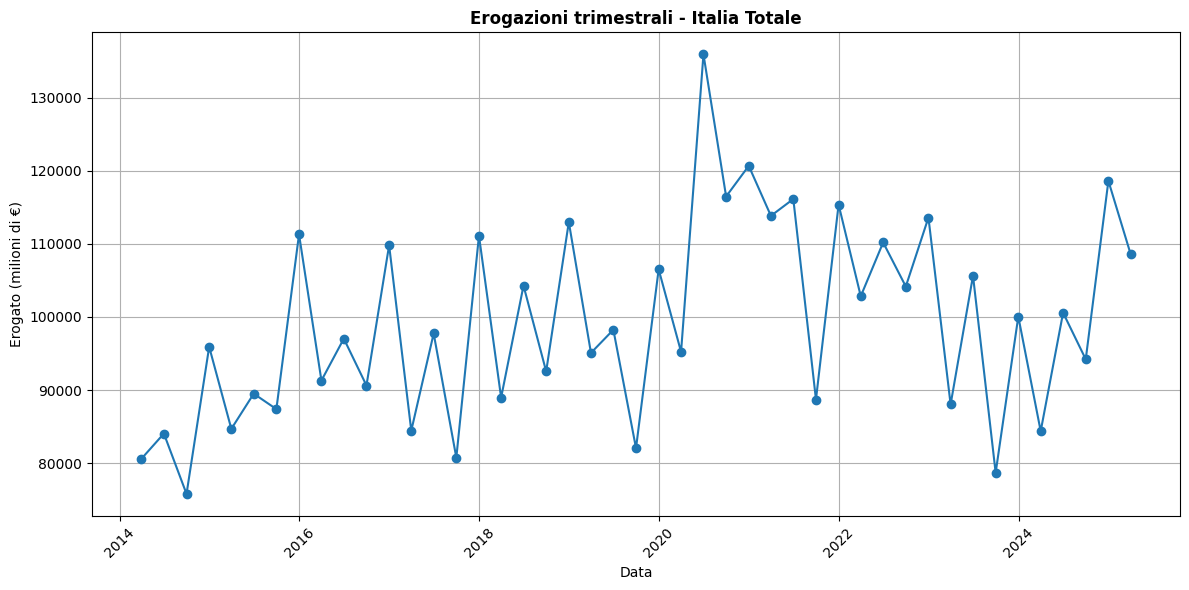

In [44]:
import matplotlib.pyplot as plt

# Crea il lineplot dei valori trimestrali
plt.figure(figsize=(12, 6))
plt.plot(valori_trimestrali['DATA_OSS'], valori_trimestrali['VALORE_MLN'], marker='o')

plt.title('Erogazioni trimestrali - Italia Totale', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Erogato (milioni di €)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


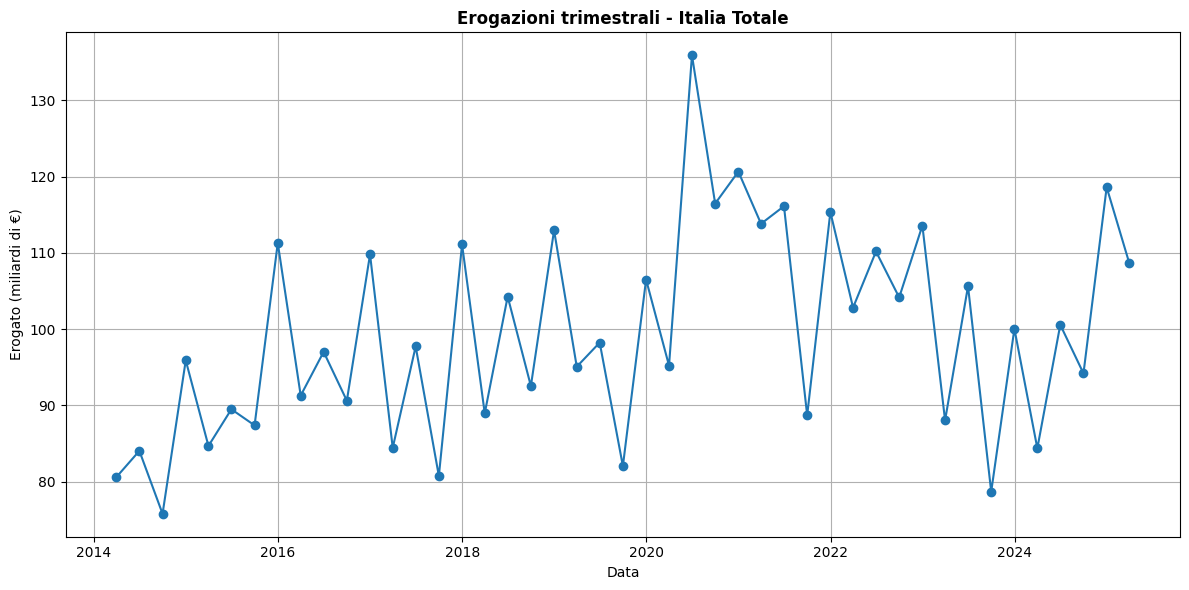

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file (modifica il nome se necessario)
# data = pd.read_csv("tuo_file.csv") oppure pd.read_parquet("tuo_file.parquet")

# Filtra il DataFrame
filtered_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['LOC_CTP'].astype(str) == 'IT') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])
filtered_df['VALORE_MLD'] = filtered_df['VALORE'] / 1e6               # miliardi di euro

# Aggrega per trimestre
valori_trimestrali = (
    filtered_df.groupby('DATA_OSS')['VALORE_MLD']
    .sum()
    .reset_index()
    .sort_values('DATA_OSS')
)

# Lineplot
plt.figure(figsize=(12, 6))
plt.plot(valori_trimestrali['DATA_OSS'], valori_trimestrali['VALORE_MLD'], marker='o')

plt.title('Erogazioni trimestrali - Italia Totale', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Erogato (miliardi di €)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
import pandas as pd

# Assumiamo che 'data' sia già caricato e pronto all'uso
# Filtro per condizioni specifiche
filtered_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['LOC_CTP'].astype(str) == 'IT') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])
filtered_df['VALORE_MLD'] = filtered_df['VALORE'] / 1e6               # in miliardi

# Aggregazione per anno
filtered_df['ANNO'] = filtered_df['DATA_OSS'].dt.year
valori_annuali = (
    filtered_df.groupby('ANNO')['VALORE_MLD']
    .sum()
    .reset_index()
    .sort_values('ANNO')
)
valori_annuali['VALORE_MLD'].round().astype(int)


0     336
1     373
2     389
3     374
4     399
5     382
6     468
7     434
8     431
9     372
10    398
11    109
Name: VALORE_MLD, dtype: int32

In [53]:
# filtered_df[['DATA_OSS','VALORE_MLD']]
filtered_df[['DATA_OSS', 'VALORE_MLD']].assign(
    VALORE_MLD = filtered_df['VALORE_MLD'].round().astype(int)
)



,DATA_OSS,VALORE_MLD
2305,2025-03-31,109
6163,2024-12-31,119
10992,2024-09-30,94
17139,2024-06-30,101
19778,2024-03-31,84
26166,2023-12-31,100
30606,2023-09-30,79
33545,2023-06-30,106
36995,2023-03-31,88
45533,2022-12-31,114


In [ ]:


# Applica il filtro e seleziona le colonne
ItaliaTOT = data[
    (data['TIPTASSO'] == '10000')              # Tasso aggregato
    & (data['LOC_CTP'] == 'IT')                # Italia
    & (data['DESINV'] == '997')                # Tutte le finalità
    & (data['ENTE_SEGN'] == '1070001')         # Fonte
].sort_values(by='DATA_OSS', ascending=True).copy()

# Conversione e scaling del valore
ItaliaTOT['VALORE'] = ItaliaTOT['VALORE'].astype('int64') * 1000
ItaliaTOT['VALORE_MLD'] = ItaliaTOT['VALORE'] / 1e9

# Colonne selezionate finali
ItaliaTOT = ItaliaTOT[['DATA_OSS', 'DESINV', 'LOC_CTP', 'TIPTASSO', 'VALORE', 'VALORE_MLD']]


In [ ]:
ItaliaTOT

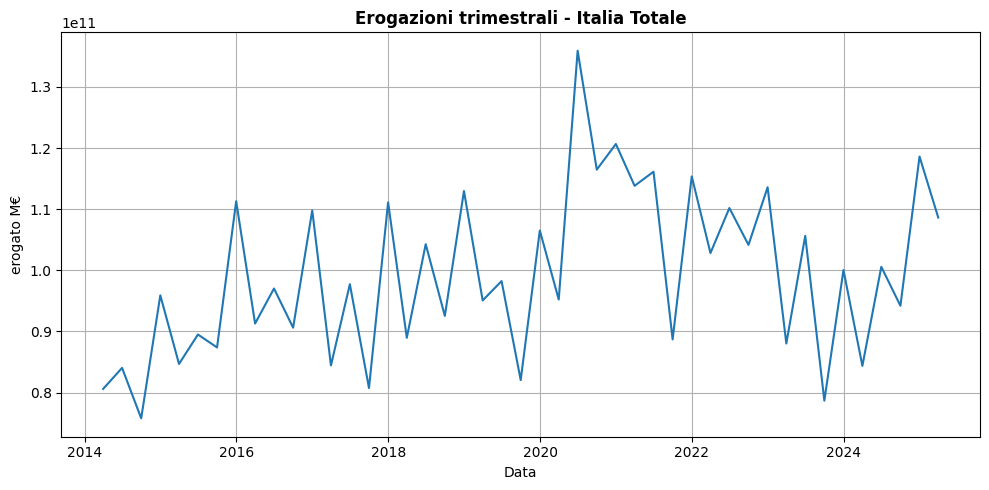

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ItaliaTOT['DATA_OSS'], ItaliaTOT['VALORE'], ) # marker='o'
plt.title('Erogazioni trimestrali - Italia Totale', weight='bold')
plt.xlabel('Data')
plt.ylabel('erogato M€')
plt.grid(True)
plt.tight_layout()
plt.show()


## facet delle 8 regioni del mezzogiorno

In [20]:
# Estrai il trimestre più recente
ultimo_periodo = data['DATA_OSS'].max()

# Definisci le due macroaree
regioni_mezzogiorno = [
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6', 'ITG1', 'ITG2'
]

# Aggiungi AREA al dataset
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['AREA'] = data['LOC_CTP'].apply(lambda x: 'Mezzogiorno' if x in regioni_mezzogiorno else 'CentroNord')

# Filtra per trimestre più recente e condizioni valide
filtered_latest = data[
    (data['DATA_OSS'] == ultimo_periodo) &
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversione VALORE in miliardi
filtered_latest['VALORE'] = filtered_latest['VALORE'].astype('int64') * 1000
filtered_latest['VALORE_MLD'] = filtered_latest['VALORE'] / 1e9

# Somma per AREA
somme_per_area = filtered_latest.groupby('AREA')['VALORE_MLD'].sum().reset_index()

somme_per_area


,AREA,VALORE_MLD
0,CentroNord,418.496759
1,Mezzogiorno,16.023360


In [26]:
# Verifica che ItaliaTOT contenga dati regionali
regionali_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
regionali_df['VALORE'] = regionali_df['VALORE'].astype('int64') * 1000
regionali_df['VALORE_MLD'] = regionali_df['VALORE'] / 1e9
regionali_df['DATA_OSS'] = pd.to_datetime(regionali_df['DATA_OSS'])

# Trova l'ultimo trimestre disponibile
ultimo_periodo = regionali_df['DATA_OSS'].max()

# Filtra per l'ultimo trimestre
ultime_regioni = regionali_df[regionali_df['DATA_OSS'] == ultimo_periodo].copy()

# Mappa dei codici regione ai nomi
regioni_nomi = {
    'ITC1': 'Piemonte',
    'ITC2': 'Valle d’Aosta',
    'ITC3': 'Liguria',
    'ITC4': 'Lombardia',
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
    'ITH10': 'Bolzano',
    'ITH20': 'Trento',
    'ITH3': 'Veneto',
    'ITH4': 'Friuli-Venezia Giulia',
    'ITH5': 'Emilia-Romagna',
    'ITI1': 'Toscana',
    'ITI2': 'Umbria',
    'ITI3': 'Marche',
    'ITI4': 'Lazio',
}

ultime_regioni['REGIONE'] = ultime_regioni['LOC_CTP'].map(regioni_nomi)

# Raggruppa per regione
erogazioni_finali = ultime_regioni.groupby(['REGIONE'])['VALORE_MLD'].sum().reset_index().sort_values('VALORE_MLD', ascending=False)
erogazioni_finali


,REGIONE,VALORE_MLD
9,Lombardia,34.580084
7,Lazio,13.857938
5,Emilia-Romagna,10.655783
20,Veneto,8.845443
12,Piemonte,7.466766
16,Toscana,6.552510
4,Campania,4.680936
15,Sicilia,3.834659
13,Puglia,3.372981
6,Friuli-Venezia Giulia,2.356341


In [28]:
erogazioni_finali['VALORE_MLD'].sum()

108.63003099999997

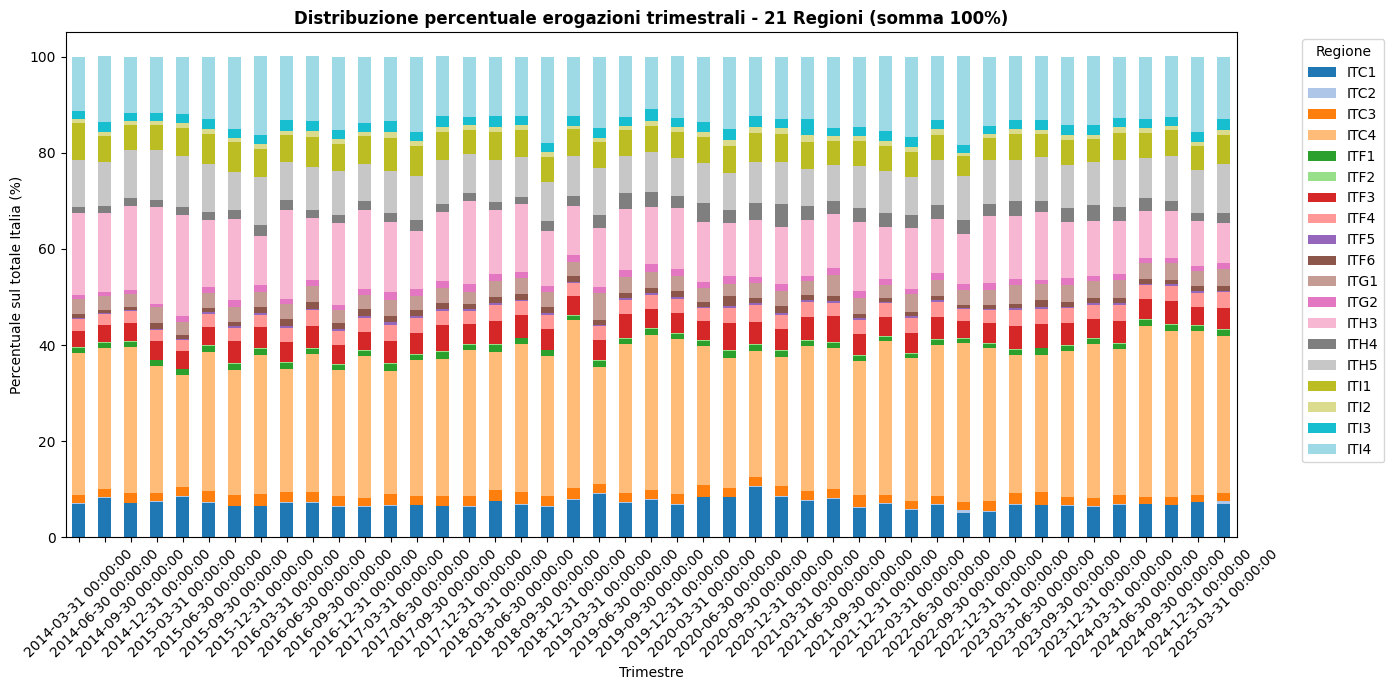

In [57]:
regioni_codici = [
    'ITC1', 'ITC2', 'ITC3', 'ITC4',     # Piemonte, Valle d’Aosta, Liguria, Lombardia
    'ITF1', 'ITF2', 'ITF3', 'ITF4',     # Abruzzo, Molise, Campania, Puglia
    'ITF5', 'ITF6',                     # Basilicata, Calabria
    'ITG1', 'ITG2',                     # Sicilia, Sardegna
    'ITH1', 'ITH2', 'ITH3', 'ITH4', 'ITH5',  # Bolzano, Trento, Veneto, FVG, Emilia-Romagna
    'ITI1', 'ITI2', 'ITI3', 'ITI4'      # Toscana, Umbria, Marche, Lazio
]


import pandas as pd
import matplotlib.pyplot as plt

# Filtro solo per le 21 regioni italiane
regioni_codici = [
    'ITC1', 'ITC2', 'ITC3', 'ITC4',
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6',
    'ITG1', 'ITG2',
    'ITH1', 'ITH2', 'ITH3', 'ITH4', 'ITH5',
    'ITI1', 'ITI2', 'ITI3', 'ITI4'
]

regioni_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_codici))
].copy()

# Conversioni
regioni_df['VALORE'] = regioni_df['VALORE'].astype('int64') * 1000
regioni_df['VALORE_MLD'] = regioni_df['VALORE'] / 1e9
regioni_df['DATA_OSS'] = pd.to_datetime(regioni_df['DATA_OSS'])

# Matrice regioni × trimestre
pivot_df = regioni_df.pivot_table(
    index='DATA_OSS',
    columns='LOC_CTP',
    values='VALORE_MLD',
    aggfunc='sum'
)

# Percentuali su base 100 per ogni trimestre
percentuali_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
percentuali_df = percentuali_df.round(2)

# Plot stacked barplot
percentuali_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20'
)

plt.title('Distribuzione percentuale erogazioni trimestrali - 21 Regioni (somma 100%)', fontweight='bold')
plt.xlabel('Trimestre')
plt.ylabel('Percentuale sul totale Italia (%)')
plt.xticks(rotation=45)
plt.legend(title='Regione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




In [63]:
import pandas as pd

# Filtro per le 21 regioni italiane
regioni_codici = [
    'ITC1','ITC2','ITC3','ITC4',
    'ITF1','ITF2','ITF3','ITF4','ITF5','ITF6',
    'ITG1','ITG2',
    'ITH1','ITH2','ITH3','ITH4','ITH5',
    'ITI1','ITI2','ITI3','ITI4'
]

df_reg = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_codici))
].copy()

# Prepara i dati
df_reg['DATA_OSS'] = pd.to_datetime(df_reg['DATA_OSS'])
df_reg['VALORE_MLD'] = df_reg['VALORE'] / 1e6

# Costruisci il pivot con valori assoluti
pivot_assoluti = df_reg.pivot_table(
    index='DATA_OSS',
    columns='LOC_CTP',
    values='VALORE_MLD',
    aggfunc='sum'
).fillna(0).sort_index()

pivot_assoluti.tail().T


DATA_OSS,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31
LOC_CTP,,,,,
ITC1,5.576034,6.727404,6.127229,8.487049,7.466766
ITC2,0.145515,0.126843,0.115476,0.13032,0.501381
ITC3,1.441007,1.295181,1.386555,1.565072,1.929861
ITC4,24.960386,34.964244,31.774956,39.490414,34.580084
ITF1,0.972593,1.121122,1.069142,1.172137,1.324889
ITF2,0.149368,0.161161,0.148296,0.189655,0.21484
ITF3,3.753021,4.152555,4.389066,4.387226,4.680936
ITF4,2.788277,2.790404,2.916459,3.498974,3.372981
ITF5,0.268107,0.340857,0.307915,0.368375,0.373017


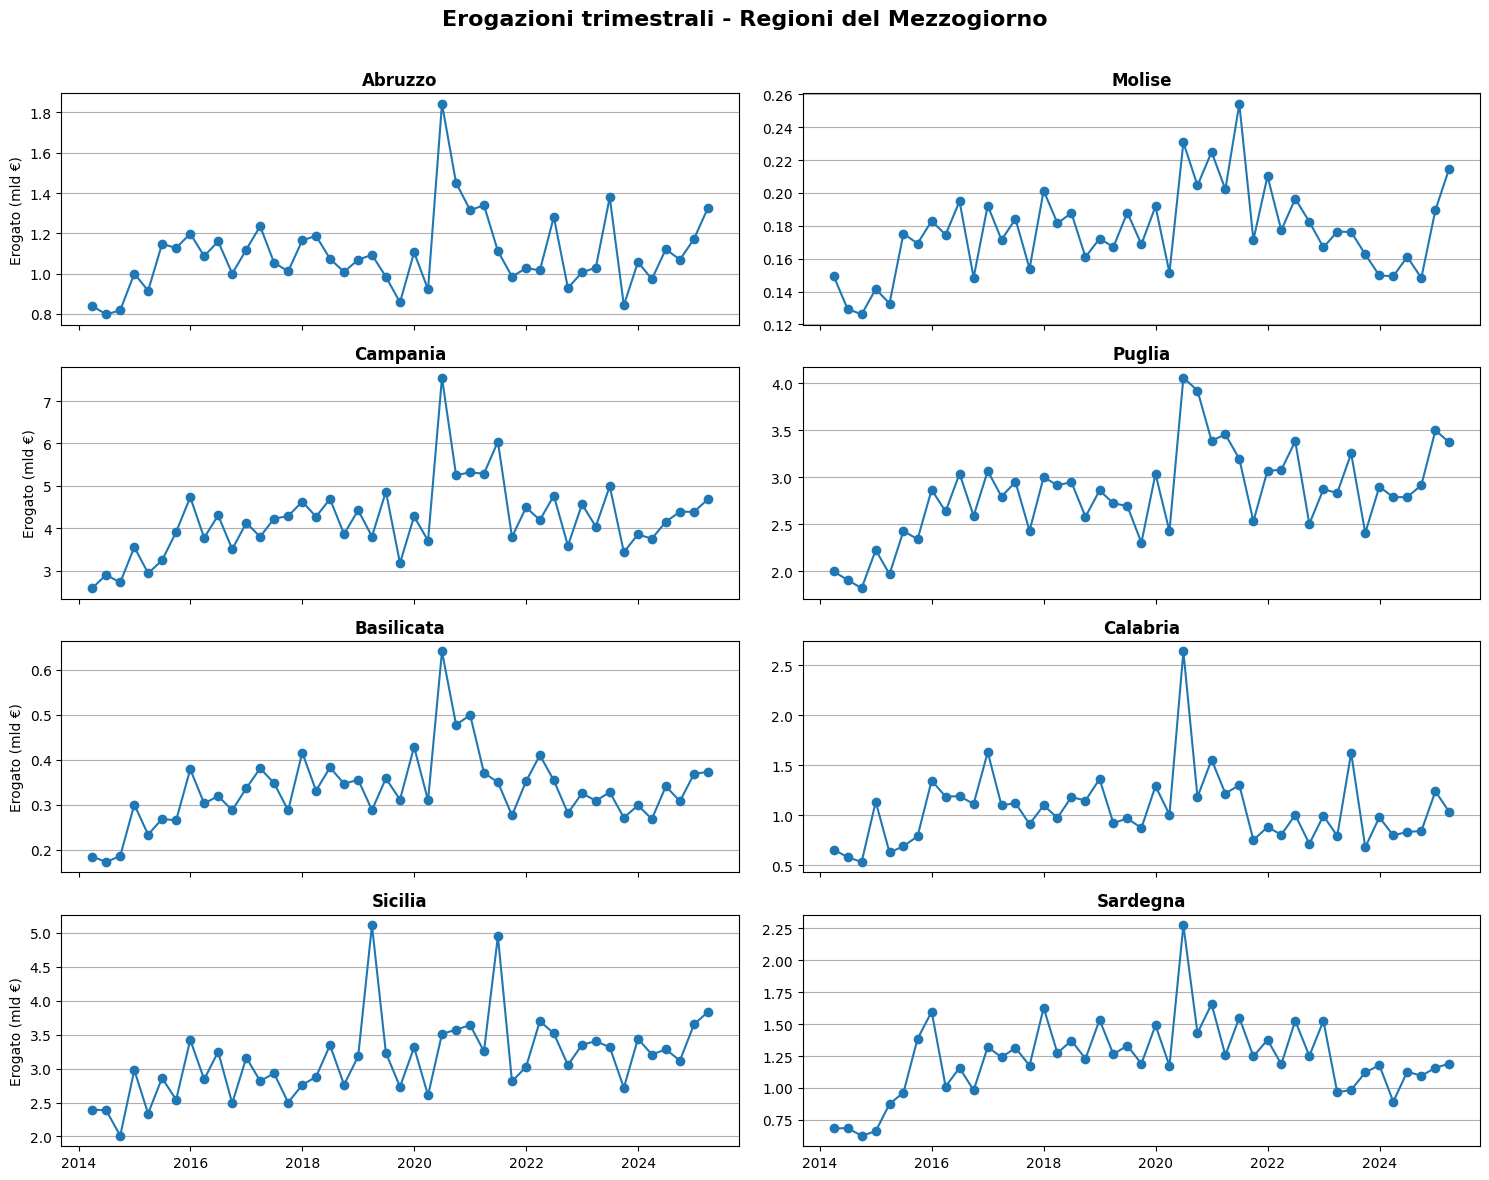

In [16]:
import matplotlib.pyplot as plt

# Lista codici regioni del Mezzogiorno (codici LOC_CTP regionali)
regioni_mezzogiorno = [
    'ITF1',  # Abruzzo
    'ITF2',  # Molise
    'ITF3',  # Campania
    'ITF4',  # Puglia
    'ITF5',  # Basilicata
    'ITF6',  # Calabria
    'ITG1',  # Sicilia
    'ITG2',  # Sardegna
]

# Filtra il DataFrame per le regioni del Mezzogiorno
mezzogiorno_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_mezzogiorno))
].copy()

# Conversioni
mezzogiorno_df['VALORE'] = mezzogiorno_df['VALORE'].astype('int64') * 1000
mezzogiorno_df['VALORE_MLD'] = mezzogiorno_df['VALORE'] / 1e9
mezzogiorno_df['DATA_OSS'] = pd.to_datetime(mezzogiorno_df['DATA_OSS'])

# Mappa dei codici ai nomi delle regioni
regioni_nomi = {
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
}
mezzogiorno_df['REGIONE'] = mezzogiorno_df['LOC_CTP'].map(regioni_nomi)

# Plot a facet (8 subplot, uno per regione) - LINEPLOT VERSION
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_nomi.values()):
    subset = mezzogiorno_df[mezzogiorno_df['REGIONE'] == regione]
    axes[i].plot(subset['DATA_OSS'], subset['VALORE_MLD'], marker='o')
    axes[i].set_title(regione, fontweight='bold')
    axes[i].tick_params(axis='x')
    axes[i].grid(True, axis='y')
    if i % 2 == 0:
        axes[i].set_ylabel('Erogato (mld €)')

fig.suptitle('Erogazioni trimestrali - Regioni del Mezzogiorno', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

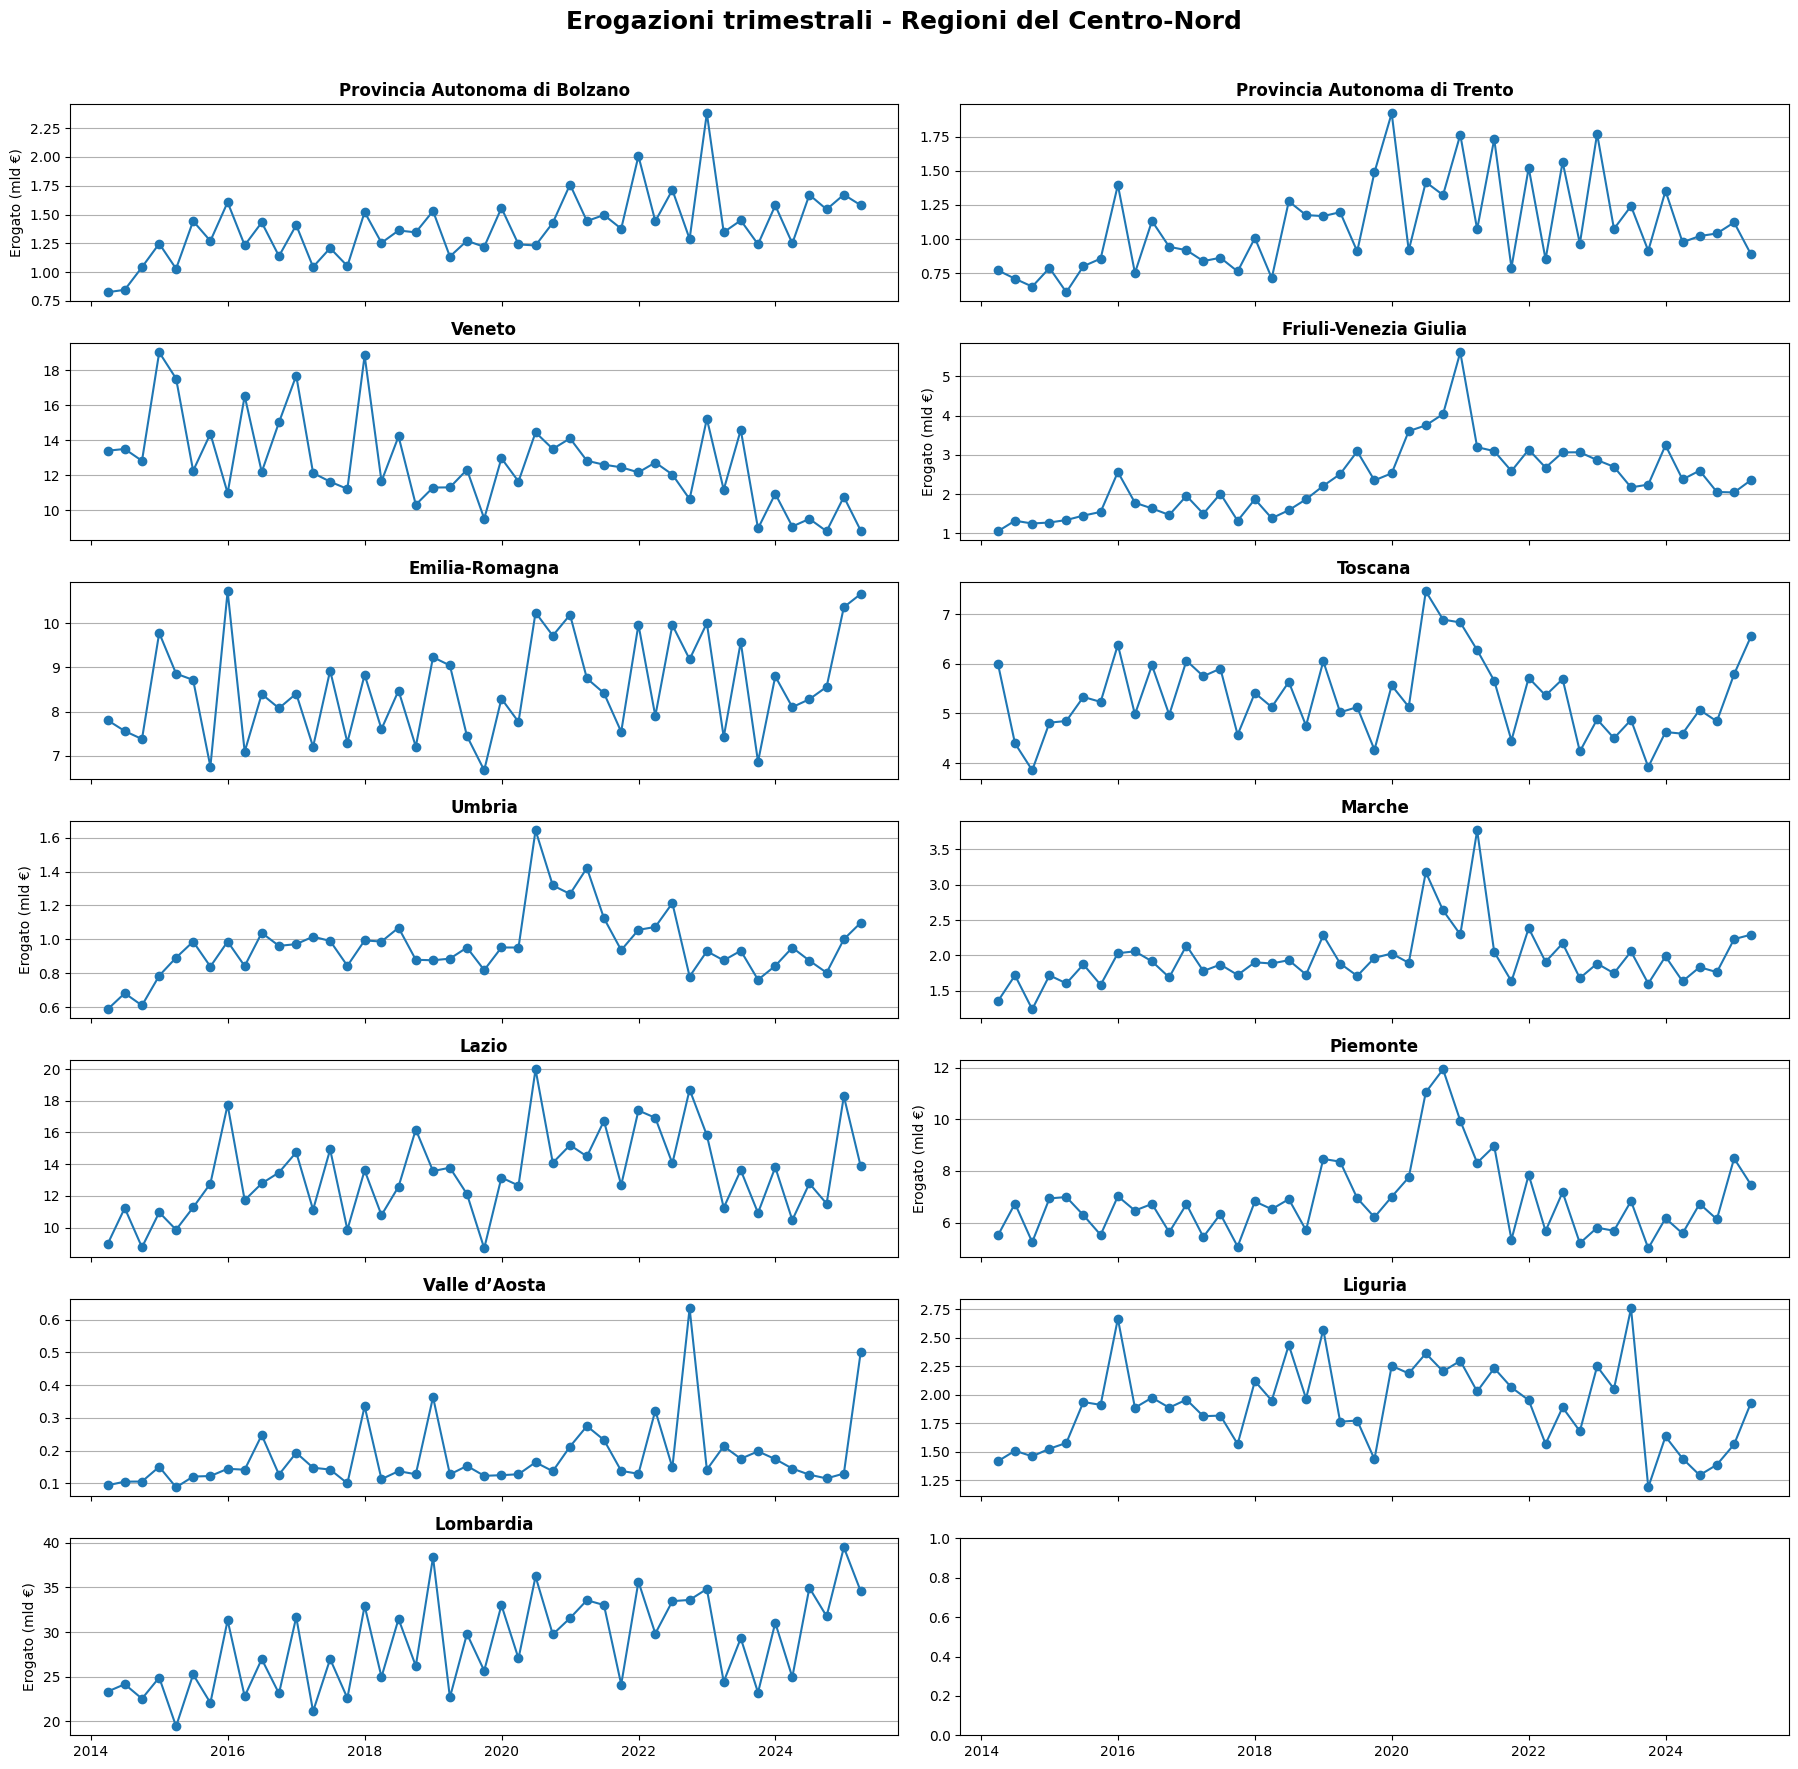

In [54]:
import matplotlib.pyplot as plt

# Codici LOC_CTP delle 18 regioni del Centro-Nord
regioni_centronord = {
    'ITH10': 'Provincia Autonoma di Bolzano',
    'ITH20': 'Provincia Autonoma di Trento',
    'ITH3': 'Veneto',
    'ITH4': 'Friuli-Venezia Giulia',
    'ITH5': 'Emilia-Romagna',
    'ITI1': 'Toscana',
    'ITI2': 'Umbria',
    'ITI3': 'Marche',
    'ITI4': 'Lazio',
    'ITC1': 'Piemonte',
    'ITC2': 'Valle d’Aosta',
    'ITC3': 'Liguria',
    'ITC4': 'Lombardia',
}

# Filtro DataFrame
centronord_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_centronord.keys()))
].copy()

# Conversioni
centronord_df['VALORE'] = centronord_df['VALORE'].astype('int64') * 1000
centronord_df['VALORE_MLD'] = centronord_df['VALORE'] / 1e9
centronord_df['DATA_OSS'] = pd.to_datetime(centronord_df['DATA_OSS'])
centronord_df['REGIONE'] = centronord_df['LOC_CTP'].map(regioni_centronord)

# Plot a facet (18 subplot, uno per regione)
fig, axes = plt.subplots(7, 2, figsize=(18, 18), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_centronord.values()):
    subset = centronord_df[centronord_df['REGIONE'] == regione]
    axes[i].plot(subset['DATA_OSS'], subset['VALORE_MLD'], marker='o')
    axes[i].set_title(regione, fontweight='bold')
    # axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y')
    if i % 3 == 0:
        axes[i].set_ylabel('Erogato (mld €)')

fig.suptitle('Erogazioni trimestrali - Regioni del Centro-Nord', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Mezzogiorno VS CentroNord

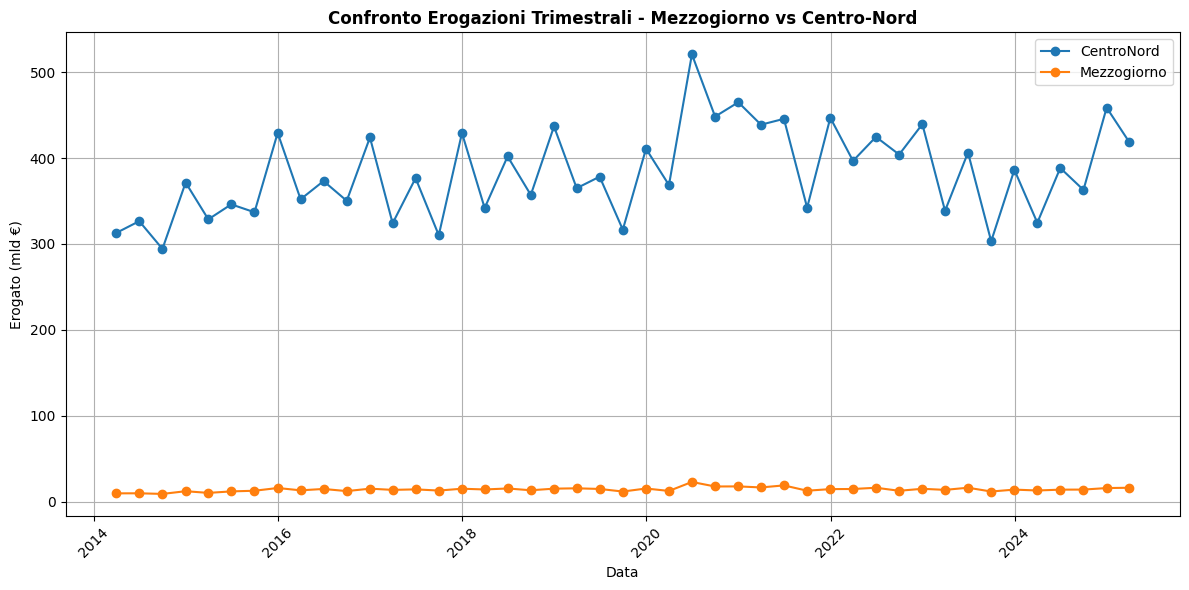

In [11]:
# Definizione codici LOC_CTP delle regioni del Mezzogiorno
regioni_mezzogiorno = [
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6', 'ITG1', 'ITG2'
]

# Prepara un DataFrame con tutto il territorio nazionale
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['TIPTASSO'] = data['TIPTASSO'].astype(str)
data['DESINV'] = data['DESINV'].astype(str)
data['ENTE_SEGN'] = data['ENTE_SEGN'].astype(str)

# Filtro per le condizioni rilevanti
filtered_df = data[
    (data['TIPTASSO'] == '10000') &
    (data['DESINV'] == '997') &
    (data['ENTE_SEGN'] == '1070001')
].copy()

# Aggiunge indicatore geografico
filtered_df['AREA'] = filtered_df['LOC_CTP'].apply(
    lambda x: 'Mezzogiorno' if x in regioni_mezzogiorno else 'CentroNord'
)

# Converte valori e date
filtered_df['VALORE'] = filtered_df['VALORE'].astype('int64') * 1000
filtered_df['VALORE_MLD'] = filtered_df['VALORE'] / 1e9
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])

# Raggruppa per area e trimestre
confronto_df = filtered_df.groupby(['DATA_OSS', 'AREA'])['VALORE_MLD'].sum().reset_index()

# Pivot per confronto diretto
pivot_df = confronto_df.pivot(index='DATA_OSS', columns='AREA', values='VALORE_MLD')

# Lineplot
plt.figure(figsize=(12, 6))
for area in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[area], marker='o', label=area)

plt.title('Confronto Erogazioni Trimestrali - Mezzogiorno vs Centro-Nord', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Erogato (mld €)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
